In [3]:
import sys, os, shutil, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K
import keras

Using TensorFlow backend.


In [30]:
def stock_prices(mu=0.01, sigma=0.3, S0=5, T=1, T_past=0, num_samples=50, num_steps=100):
    S=np.zeros([num_samples, num_steps+1])
    S[:,0]=S0
    dt=T/num_steps
    sqrt_dt=np.sqrt(dt)
    
    num_past_steps=int(T_past // dt)
    Spast=np.zeros([num_samples, num_past_steps+1])
    Spast[:,0]=S0
    
    
    normal_sample=np.random.normal(0,1,[num_samples, num_steps])
    normal_sample_past=np.random.normal(0,1,[num_samples, num_past_steps])
    if (type(mu) is list) or (type(mu) is tuple):
        Mu=np.random.uniform(mu[0], mu[1], num_samples)
    else:
        Mu=mu
    if (type(sigma) is list) or (type(sigma) is tuple):
        Sigma=np.random.uniform(sigma[0], sigma[1], num_samples)
    else:
        Sigma=sigma
        
    for k in range(1,num_steps+1):
        S[:,k]=S[:,k-1] + Mu*S[:,k-1]*dt + Sigma*S[:,k-1]*normal_sample[:,k-1]*sqrt_dt
    for k in range(1,num_past_steps+1):
        Spast[:,k]=Spast[:,k-1] + Mu*Spast[:,k-1]*dt + Sigma*Spast[:,k-1]*normal_sample_past[:,k-1]*sqrt_dt
    Spast=Spast[:,1:]
    Spast=np.fliplr(Spast)
    S=np.hstack([Spast,S])
    
    timepoints=np.hstack([np.arange(-num_past_steps,0), np.array([0]), np.arange(1, num_steps+1)])*dt
    return S, timepoints 


def stock_prices_generator(mu=0.05, sigma=0.3, S0=5, T=1, T_past=0, num_samples=50, num_steps=100, maxgen=np.inf, randomseed=None, modelinput=False):
    if randomseed is not None:
        np.random.seed(randomseed)
    _, timepts=stock_prices(mu, sigma, S0, T, T_past, num_samples, num_steps)
    timepoints=np.ones((num_samples,1)).dot(timepts.reshape(1,-1))
    
    k=0
    while k<maxgen:
        k=k+1
        S, _=stock_prices(mu, sigma, S0, T, T_past, num_samples, num_steps)
        if modelinput:
            input_to_train=[np.expand_dims(S, axis=2), np.expand_dims(timepoints, axis=2)]
            dummy_target=np.zeros([S.shape[0], S.shape[1], 3])
            yield input_to_train, dummy_target
        else:
            yield S
        

In [31]:
num_past_steps=3
num_steps=5
np.hstack([np.arange(-num_past_steps,0), np.array([0]), np.arange(1, num_steps+1)])

array([-3, -2, -1,  0,  1,  2,  3,  4,  5])

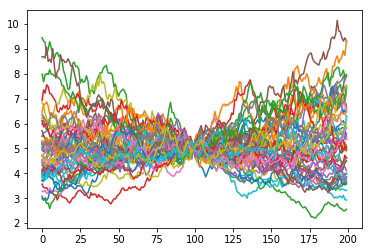

In [32]:
gen=stock_prices_generator(T_past=1)
plt.plot(gen.__next__().T)
plt.show()

In [33]:
gen.__next__().shape

(50, 200)

In [34]:
gen2=stock_prices_generator(modelinput=True, T_past=1)
out=gen2.__next__()
out[0][0].shape, out[0][1].shape, out[1].shape

((50, 200, 1), (50, 200, 1), (50, 200, 3))

In [35]:
out[1][:,:int(out[1].shape[1]/2)].shape

(50, 100, 3)

In [40]:
def EuroOptionPrice_MonteCarlo(r=0.05, sigma=0.3, S0=5, T=1, K=5, Type='call', num_samples=50, num_steps=100):
    S, _=stock_prices(mu=r, sigma=sigma, S0=S0, T=T, T_past=0, num_samples=num_samples, num_steps=num_steps)
    if Type=='call':
        return np.maximum(S[:,-1]-K,0).mean()
    elif Type=='put':
        return np.maximum(K-S[:,-1],0).mean()
    else:
        raise ValueError('Invalid option Type: vslid options are "call" or "put".')
    

In [41]:
EuroOptionPrice_MonteCarlo(num_samples=40000, num_steps=800)

0.7541349827667909

In [42]:
EuroOptionPrice_MonteCarlo(num_samples=10000, num_steps=100, Type='put')

0.4798531321132639

check https://goodcalculators.com/black-scholes-calculator/

In [43]:
def AmericanOptionLSTM(timesteps,LSTM=False, units=20):
    stock_prices=keras.layers.Input(shape=(timesteps+1,1), name='Stock_prices')
    timepoints=keras.layers.Input(shape=(timesteps+1,1), name='Timepoints')
    
    x=stock_prices
    if LSTM:
        x=keras.layers.LSTM(units=units, return_sequences=True, name='LSTM1', activation='hard_sigmoid')(x)
    else:
        x=keras.layers.Conv1D(filters=units, kernel_size=1, name='FC1-Conv', activation='hard_sigmoid')(x)
    x=keras.layers.Concatenate(axis=2, name='ConcatTime')([x,timepoints])
    if LSTM:
        x=keras.layers.LSTM(units=1, return_sequences=True, name='LSTM2', activation='hard_sigmoid')(x)
    else:
        x=keras.layers.Conv1D(filters=int(units//2), kernel_size=1,name='FC2-Conv0', activation='elu')(x)
        x=keras.layers.Conv1D(filters=int(units//4), kernel_size=1,name='FC2-Conv1', activation='elu')(x)
        x=keras.layers.Conv1D(filters=1, kernel_size=1,name='FC2-Conv2', activation='hard_sigmoid')(x)
    #x=keras.layers.Conv1D(filters=2,kernel_size=1)(x)
    outputs=keras.layers.Concatenate(name='Output', axis=2)([x,stock_prices,timepoints])
    return keras.models.Model(inputs=[stock_prices, timepoints], outputs=outputs)

In [49]:
def profit_loss(dummy_target, stockdata):
    
    # stockprices
    stockprice=stockdata[:,:,1]#inputdata
    # timestep
    timepoint=stockdata[:,:,2]
    # probability that we will exercise at the given time if we still havent
    exerprob=stockdata[:,:,0]#K.squeeze(exerprob, axis=2)
    
    # probabilty that we havent exercised the option yet
    pshift=K.concatenate([K.zeros_like(exerprob[:,0:1]),exerprob[:,:-1]])
    one_minus_pshift=1-pshift
    prob_notexercisedbefore=K.cumprod(one_minus_pshift, axis=1)
    
    # probability of using option at the given time:
    willexerprob=exerprob*prob_notexercisedbefore
    
    # profit for exercising at current time:
    profit=K.maximum(stockprice-5,0)
    
    # discounting profit:
    interest_rate=0.05
    profit=K.exp(-interest_rate*timepoint)*profit
    
    # average profit:
    ap=K.sum(profit*willexerprob, axis=1)
    return -K.mean(ap)
    
def mse2(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [50]:
network=AmericanOptionLSTM(100, LSTM=False)
network.compile(loss=profit_loss, optimizer='adam')

In [51]:
network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Stock_prices (InputLayer)       (None, 101, 1)       0                                            
__________________________________________________________________________________________________
FC1-Conv (Conv1D)               (None, 101, 20)      40          Stock_prices[0][0]               
__________________________________________________________________________________________________
Timepoints (InputLayer)         (None, 101, 1)       0                                            
__________________________________________________________________________________________________
ConcatTime (Concatenate)        (None, 101, 21)      0           FC1-Conv[0][0]                   
                                                                 Timepoints[0][0]                 
__________

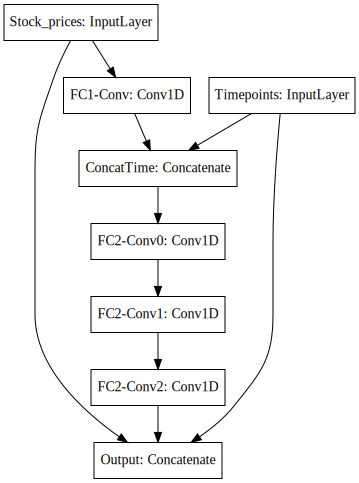

In [52]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(network, show_shapes=False, show_layer_names=True).create(prog='dot', format='svg'))

In [53]:
gen2.__next__()[0][0].shape

(50, 200, 1)

In [54]:
gen2=stock_prices_generator(modelinput=True)
network.fit_generator(gen2, epochs=1000, steps_per_epoch=1000)

Epoch 1/1000
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6003
Epoch 2/1000
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6624
Epoch 3/1000
1000/1000 [==============================] - 17s 17ms/step - loss: -0.6704
Epoch 4/1000
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6776
Epoch 5/1000
1000/1000 [==============================] - 15s 15ms/step - loss: -0.6772
Epoch 6/1000
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6810
Epoch 7/1000
1000/1000 [==============================] - 15s 15ms/step - loss: -0.6976
Epoch 8/1000
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6955
Epoch 9/1000
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6913
Epoch 10/1000
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6935
Epoch 11/1000
1000/1000 [==============================] - 15s 15ms/step - loss: -0.6939
Epoch 12/1000
1000/1000 [=====

KeyboardInterrupt: 

In [59]:
X,y=gen2.__next__()
exerp=network.predict(X)
stockp=y
exerp, stockp.shape
exerp[:,:,0][0].shape

(101,)

In [353]:
exerp[:,-4,:].T, stockp[:,-1,:].T

(array([[1.        , 0.14450628, 0.30169255, 0.        , 1.        ,
         0.        , 0.5932659 , 0.9176781 , 1.        , 0.        ,
         0.        , 1.        , 1.        , 1.        , 1.        ,
         0.        , 1.        , 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.5615582 , 0.        , 0.        ,
         1.        , 0.39710447, 0.        , 0.        , 0.        ,
         1.        , 0.        , 1.        , 0.        , 1.        ,
         1.        , 1.        , 0.        , 0.        , 0.        ,
         1.        , 1.        , 1.        , 0.        , 1.        ,
         0.        , 0.        , 1.        , 1.        , 0.        ]],
       dtype=float32),
 array([[5.62272006, 5.41160351, 5.07301452, 2.81136773, 5.86587577,
         4.05612561, 5.17707369, 5.20995478, 5.36740771, 3.81167902,
         4.50217934, 5.54650698, 5.42847903, 5.76938627, 5.18716275,
         2.40798966, 8.9320974 , 5.08204536, 4.94533215, 4.12974736,
         

In [275]:
exerp.sum(axis=1)

array([[ 0.       ],
       [12.633636 ],
       [ 0.       ],
       [11.982477 ],
       [ 0.       ],
       [12.937766 ],
       [12.970039 ],
       [ 4.       ],
       [ 0.       ],
       [12.027296 ],
       [ 0.       ],
       [ 0.       ],
       [ 3.5909991],
       [ 1.6935468],
       [ 0.       ],
       [12.685236 ],
       [12.570408 ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 4.695881 ],
       [12.563227 ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 1.1452655],
       [ 5.2492466],
       [ 0.       ],
       [12.6809635],
       [ 0.       ],
       [ 0.       ],
       [12.427646 ],
       [ 0.       ],
       [ 0.       ],
       [12.581484 ],
       [12.541426 ],
       [11.518965 ],
       [ 3.3416123],
       [ 0.       ],
       [12.9056835],
       [ 0.       ],
       [12.466864 ],
       [ 0.       ],
       [ 0.       ],
       [ 0.  

In [18]:
from keras.utils import plot_model
import matplotlib.image as mpimg
path='/home/igor/Desktop/model.png'

plot_model(network, to_file='/home/igor/Desktop/model.png', show_shapes=True, show_layer_names=False)

In [117]:
p=K.constant([0.8, 0.5, 0.3])
pshift=K.concatenate([K.constant([0]),p[:-1]])
notpshift=1-pshift
pnotbefore=K.cumprod(notpshift)
pfinal=p*pnotbefore

#cc=K.concatenate([tf.constant([1.]),aa])
#cc=K.cumprod(cc)
with tf.Session() as sess:
    b=sess.run(pfinal)
b

array([0.8       , 0.09999999, 0.03      ], dtype=float32)

In [179]:
stockprice=K.constant(stockp)
exerprob=K.constant(exerp)

def profit_loss(stockprice, exerprob):
    # stockprice
    stockprice=K.squeeze(stockprice, axis=2)
    # probability that we will exercise at the given time if we still havent
    exerprob=K.squeeze(exerprob, axis=2)
    
    # probabilty that we havent exercised the option yet
    pshift=K.concatenate([K.zeros_like(exerprob[:,0:1]),exerprob[:,:-1]])
    one_minus_pshift=1-pshift
    prob_notexercisedbefore=K.cumprod(one_minus_pshift, axis=1)
    
    # probability of using option at the given time:
    willexerprob=exerprob*prob_notexercisedbefore
    
    # profit for exercising at current time:
    profit=stockprice-5
    
    # average profit:
    ap=profit*willexerprob
    return -K.mean(ap)
                          
a=profit_loss(stockprice, exerprob)
                          
with tf.Session() as sess:
    out=sess.run(a)
out

5.57627e-05

In [169]:
s=K.constant(stockprice)
s=K.squeeze(s, axis=2)
ss=K.concatenate([K.zeros_like(s[:,0:1]),s[:,:-1]])
with tf.Session() as sess:
    c=sess.run(s)
    a=sess.run(ss)
c.shape, a.shape

TypeError: Expected float32, got list containing Tensors of type '_Message' instead.

In [111]:
a

array([[0.       , 5.       , 5.014791 , ..., 2.5195274, 2.4378657,
        2.359516 ],
       [0.       , 5.       , 5.0373597, ..., 6.247162 , 6.353185 ,
        6.244947 ],
       [0.       , 5.       , 5.0486026, ..., 3.6712966, 3.4974246,
        3.5301914],
       ...,
       [0.       , 5.       , 5.113618 , ..., 3.7634332, 3.6805155,
        3.8008263],
       [0.       , 5.       , 5.066696 , ..., 6.3140936, 6.235577 ,
        6.455458 ],
       [0.       , 5.       , 5.114383 , ..., 3.6436484, 3.6787958,
        3.58184  ]], dtype=float32)